# UCI SECOM Semiconductor Defect Detection Analysis

**Objective**: Predict semiconductor manufacturing failures (defects) using sensor data.

**Approach**:
1. Label-free feature engineering (to avoid data leakage)
2. Multiple resampling strategies for class imbalance
3. Multiple models with hyperparameter tuning via CV
4. Primary metric: Recall@Precision>0.2
5. SHAP interpretability for top performers

In [ ]:
# Cell 0: Install required libraries (run once)
# Uncomment and run if any packages are missing

!pip install pandas numpy matplotlib seaborn scikit-learn lightgbm xgboost imbalanced-learn shap --quiet

print("All required packages installed!")

In [3]:
# Cell 1: Setup and Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    f1_score, precision_recall_curve, auc,
    confusion_matrix, classification_report,
    average_precision_score, recall_score, precision_score
)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN
import shap
import warnings
from itertools import product
from collections import defaultdict

warnings.filterwarnings('ignore')
np.random.seed(42)

print("All imports successful!")

All imports successful!


In [4]:
# Cell 2: Load Data
df = pd.read_csv('uci-secom.csv')

# Rename target column
df = df.rename(columns={'Pass/Fail': 'target'})

# Convert target: -1 (Pass) -> 0, 1 (Fail) -> 1
df['target'] = df['target'].map({-1: 0, 1: 1})

print(f"Dataset shape: {df.shape}")
print(f"\nTarget distribution:")
print(df['target'].value_counts())
print(f"\nDefect rate: {df['target'].mean():.2%}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (1567, 592)

Target distribution:
target
0    1463
1     104
Name: count, dtype: int64

Defect rate: 6.64%

First few rows:


,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,target
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,0
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,0
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,0
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,0


In [5]:
# Cell 3: Train-Test Split (80/20 stratified)

# Separate features and target
# Drop 'Time' column if it exists (not a sensor feature)
feature_cols = [col for col in df.columns if col not in ['target', 'Time']]
X = df[feature_cols]
y = df['target']

print(f"Total features: {len(feature_cols)}")

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTrain defect rate: {y_train.mean():.2%}")
print(f"Test defect rate: {y_test.mean():.2%}")

Total features: 590

Train set: 1253 samples
Test set: 314 samples

Train defect rate: 6.62%
Test defect rate: 6.69%


## Feature Engineering (Label-Free)

All feature selection is done without looking at labels to prevent data leakage.

In [6]:
# Cell 4: Remove columns with >=80% missing values

# Calculate missingness on training set
missing_pct = X_train.isnull().mean() * 100

# Columns to drop (>=80% missing)
cols_drop_high_missing = missing_pct[missing_pct >= 80].index.tolist()

print(f"Columns with >=80% missing: {len(cols_drop_high_missing)}")
print(f"Examples: {cols_drop_high_missing[:5]}")

# Store for later
feature_engineering_log = {'original_features': len(feature_cols)}
feature_engineering_log['dropped_high_missing'] = len(cols_drop_high_missing)

Columns with >=80% missing: 8
Examples: ['85', '157', '158', '220', '292']


In [7]:
# Cell 5: Create missingness indicators for 50-80% missing columns

# Columns with 50-80% missing
cols_medium_missing = missing_pct[(missing_pct >= 50) & (missing_pct < 80)].index.tolist()

print(f"Columns with 50-80% missing: {len(cols_medium_missing)}")

# Create missingness indicator column names
missingness_indicators = [f"{col}_missing" for col in cols_medium_missing]

feature_engineering_log['medium_missing_to_indicators'] = len(cols_medium_missing)

Columns with 50-80% missing: 16


In [8]:
# Cell 6: Remove constant and near-constant columns

# Work with remaining columns (exclude high missing ones)
remaining_cols = [col for col in X_train.columns 
                  if col not in cols_drop_high_missing and col not in cols_medium_missing]

cols_to_drop_constant = []

for col in remaining_cols:
    col_data = X_train[col].dropna()
    
    if len(col_data) == 0:
        cols_to_drop_constant.append(col)
        continue
    
    # Check 1: Single unique value
    if col_data.nunique() == 1:
        cols_to_drop_constant.append(col)
        continue
    
    # Check 2: IQR = 0 (zero variability in middle 50%)
    q1, q3 = col_data.quantile([0.25, 0.75])
    if q3 - q1 == 0:
        cols_to_drop_constant.append(col)
        continue
    
    # Check 3: Top value >99% frequency
    top_freq = col_data.value_counts(normalize=True).iloc[0]
    if top_freq > 0.99:
        cols_to_drop_constant.append(col)
        continue
    
    # Check 4: count_nonmode < 20
    mode_val = col_data.mode().iloc[0] if len(col_data.mode()) > 0 else None
    if mode_val is not None:
        count_nonmode = (col_data != mode_val).sum()
        if count_nonmode < 20:
            cols_to_drop_constant.append(col)
            continue

print(f"Columns dropped (constant/near-constant): {len(cols_to_drop_constant)}")

feature_engineering_log['dropped_constant'] = len(cols_to_drop_constant)

Columns dropped (constant/near-constant): 126


In [9]:
# Cell 7: Remove highly correlated columns (>95%)

# Get columns remaining after previous steps
cols_for_corr = [col for col in remaining_cols if col not in cols_to_drop_constant]

print(f"Checking correlation among {len(cols_for_corr)} columns...")

# Standardize columns before calculating variability metrics
# This ensures IQR comparison is scale-invariant
temp_imputer = SimpleImputer(strategy='median')
temp_scaler = StandardScaler()

X_corr_imputed = pd.DataFrame(
    temp_imputer.fit_transform(X_train[cols_for_corr]),
    columns=cols_for_corr,
    index=X_train.index
)
X_corr_scaled = pd.DataFrame(
    temp_scaler.fit_transform(X_corr_imputed),
    columns=cols_for_corr,
    index=X_train.index
)

# Calculate correlation matrix (use pairwise complete observations)
corr_matrix = X_train[cols_for_corr].corr().abs()

# Pre-compute IQR for all columns (on standardized data)
iqr_dict = {}
for col in cols_for_corr:
    q1, q3 = X_corr_scaled[col].quantile([0.25, 0.75])
    iqr_dict[col] = q3 - q1

# Find highly correlated pairs
cols_to_drop_corr = set()
checked_pairs = set()

for i, col1 in enumerate(cols_for_corr):
    for col2 in cols_for_corr[i+1:]:
        if (col1, col2) in checked_pairs or col1 in cols_to_drop_corr or col2 in cols_to_drop_corr:
            continue

        corr_val = corr_matrix.loc[col1, col2]

        if corr_val > 0.95:
            # Decide which to drop based on:
            # 1. More missing values
            # 2. Lower variability (IQR on standardized data)
            missing1 = X_train[col1].isnull().sum()
            missing2 = X_train[col2].isnull().sum()

            if missing1 != missing2:
                drop_col = col1 if missing1 > missing2 else col2
            else:
                iqr1 = iqr_dict[col1]
                iqr2 = iqr_dict[col2]
                drop_col = col1 if iqr1 < iqr2 else col2

            cols_to_drop_corr.add(drop_col)

        checked_pairs.add((col1, col2))

cols_to_drop_corr = list(cols_to_drop_corr)
print(f"Columns dropped (high correlation): {len(cols_to_drop_corr)}")

feature_engineering_log['dropped_correlated'] = len(cols_to_drop_corr)

Checking correlation among 440 columns...
Columns dropped (high correlation): 169


In [10]:
# Cell 8: Lock feature set

# Final feature columns (original features to keep)
all_cols_to_drop = set(cols_drop_high_missing + cols_medium_missing + 
                       cols_to_drop_constant + cols_to_drop_corr)

final_feature_cols = [col for col in feature_cols if col not in all_cols_to_drop]

# Add missingness indicators to final feature list
final_feature_cols_with_indicators = final_feature_cols + missingness_indicators

print("="*60)
print("FEATURE ENGINEERING SUMMARY")
print("="*60)
print(f"Original features: {feature_engineering_log['original_features']}")
print(f"Dropped (>=80% missing): {feature_engineering_log['dropped_high_missing']}")
print(f"Converted to indicators (50-80% missing): {feature_engineering_log['medium_missing_to_indicators']}")
print(f"Dropped (constant/near-constant): {feature_engineering_log['dropped_constant']}")
print(f"Dropped (high correlation): {feature_engineering_log['dropped_correlated']}")
print(f"\nFinal numeric features: {len(final_feature_cols)}")
print(f"Missingness indicators: {len(missingness_indicators)}")
print(f"Total final features: {len(final_feature_cols_with_indicators)}")

# Store for later use
FINAL_NUMERIC_COLS = final_feature_cols
MISSINGNESS_INDICATOR_SOURCE_COLS = cols_medium_missing
MISSINGNESS_INDICATOR_COLS = missingness_indicators

FEATURE ENGINEERING SUMMARY
Original features: 590
Dropped (>=80% missing): 8
Converted to indicators (50-80% missing): 16
Dropped (constant/near-constant): 126
Dropped (high correlation): 169

Final numeric features: 271
Missingness indicators: 16
Total final features: 287


In [11]:
# Cell 9: Define CV Splits

N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

print(f"Using {N_SPLITS}-fold stratified cross-validation")

# Preview fold sizes
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"Fold {fold_idx+1}: Train={len(train_idx)}, Val={len(val_idx)}, "
          f"Val defect rate={y_train.iloc[val_idx].mean():.2%}")

Using 5-fold stratified cross-validation
Fold 1: Train=1002, Val=251, Val defect rate=6.77%
Fold 2: Train=1002, Val=251, Val defect rate=6.77%
Fold 3: Train=1002, Val=251, Val defect rate=6.77%
Fold 4: Train=1003, Val=250, Val defect rate=6.40%
Fold 5: Train=1003, Val=250, Val defect rate=6.40%


## Processing Functions

In [12]:
# Cell 10: Data preparation function

def prepare_features(X_data, numeric_cols, indicator_source_cols, indicator_cols):
    """
    Prepare feature matrix by:
    1. Selecting numeric columns
    2. Creating missingness indicators
    """
    # Select numeric features
    X_numeric = X_data[numeric_cols].copy()
    
    # Create missingness indicators
    for src_col, ind_col in zip(indicator_source_cols, indicator_cols):
        if src_col in X_data.columns:
            X_numeric[ind_col] = X_data[src_col].isnull().astype(int)
        else:
            X_numeric[ind_col] = 0
    
    return X_numeric

print("prepare_features() defined")

prepare_features() defined


In [13]:
# Cell 11: Imputation and scaling functions

def impute_and_scale(X_train_fold, X_val_fold):
    """
    Impute missing values with median and scale features.
    Fitted on training fold only, applied to both.
    """
    # Imputation
    imputer = SimpleImputer(strategy='median')
    X_train_imputed = pd.DataFrame(
        imputer.fit_transform(X_train_fold),
        columns=X_train_fold.columns,
        index=X_train_fold.index
    )
    X_val_imputed = pd.DataFrame(
        imputer.transform(X_val_fold),
        columns=X_val_fold.columns,
        index=X_val_fold.index
    )
    
    # Scaling
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train_imputed),
        columns=X_train_imputed.columns,
        index=X_train_imputed.index
    )
    X_val_scaled = pd.DataFrame(
        scaler.transform(X_val_imputed),
        columns=X_val_imputed.columns,
        index=X_val_imputed.index
    )
    
    return X_train_scaled, X_val_scaled, imputer, scaler

print("impute_and_scale() defined")

impute_and_scale() defined


In [14]:
# Cell 12: Resampling strategies

def apply_resampling(X_train_fold, y_train_fold, strategy):
    """
    Apply resampling strategy to training data.
    
    Strategies:
    - 'none': No resampling (use class weights in model)
    - 'undersample': Random undersampling to 1:3 pos:neg ratio
    - 'smote_tomek': SMOTE + Tomek links
    - 'smote_enn': SMOTE + ENN (k=3)
    """
    if strategy == 'none':
        return X_train_fold, y_train_fold
    
    elif strategy == 'undersample':
        # Target 1:3 ratio (pos:neg)
        n_pos = y_train_fold.sum()
        n_neg_target = n_pos * 3
        
        rus = RandomUnderSampler(
            sampling_strategy={0: min(n_neg_target, (y_train_fold == 0).sum()), 1: n_pos},
            random_state=42
        )
        X_resampled, y_resampled = rus.fit_resample(X_train_fold, y_train_fold)
        return X_resampled, y_resampled
    
    # changed the sampling strategy to match 1:3
    elif strategy == 'smote_tomek':
        # SMOTE first, then Tomek links
        n_pos = y_train_fold.sum()
        k_neighbors = min(3, n_pos - 1) if n_pos > 1 else 1
        
        smote_tomek = SMOTETomek(
            smote=SMOTE(k_neighbors=k_neighbors, sampling_strategy=0.33, random_state=42),
            random_state=42
        )
        X_resampled, y_resampled = smote_tomek.fit_resample(X_train_fold, y_train_fold)
        return X_resampled, y_resampled
    
    elif strategy == 'smote_enn':
        # SMOTE + ENN with k=3
        n_pos = y_train_fold.sum()
        k_neighbors = min(3, n_pos - 1) if n_pos > 1 else 1
        
        smote_enn = SMOTEENN(
            smote=SMOTE(k_neighbors=k_neighbors, sampling_strategy=0.33, random_state=42),
            random_state=42
        )
        X_resampled, y_resampled = smote_enn.fit_resample(X_train_fold, y_train_fold)
        return X_resampled, y_resampled
    
    else:
        raise ValueError(f"Unknown resampling strategy: {strategy}")

RESAMPLING_STRATEGIES = ['none', 'undersample', 'smote_tomek', 'smote_enn']
print(f"Resampling strategies: {RESAMPLING_STRATEGIES}")

Resampling strategies: ['none', 'undersample', 'smote_tomek', 'smote_enn']


## Model Definitions

In [15]:
# Cell 13: Define model configurations with hyperparameter grids

MODEL_CONFIGS = {
    'LogisticRegression': {
        'model_class': LogisticRegression,
        'base_params': {'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 1000, 'random_state': 42},
        'param_grid': {
            'C': [0.01, 0.1, 1.0],
            'l1_ratio': [0.3, 0.5, 0.7]
        }
    },
    'LightGBM': {
        'model_class': LGBMClassifier,
        'base_params': {'random_state': 42, 'verbose': -1, 'n_jobs': -1},
        'param_grid': {
            'num_leaves': [15, 31],
            'min_data_in_leaf': [10, 20],
            'learning_rate': [0.05, 0.1]
        }
    },
    'XGBoost': {
        'model_class': XGBClassifier,
        'base_params': {'random_state': 42, 'eval_metric': 'logloss', 'n_jobs': -1},
        'param_grid': {
            'max_depth': [3, 5],
            'min_child_weight': [1, 5],
            'learning_rate': [0.05, 0.1]  # XGBoost uses learning_rate, not eta
        }
    },
    'RandomForest': {
        'model_class': RandomForestClassifier,
        'base_params': {'random_state': 42, 'n_jobs': -1},
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [5, 10],
            'min_samples_leaf': [5, 10]
        }
    }
}

# Display grid sizes
for model_name, config in MODEL_CONFIGS.items():
    grid_size = 1
    for param_values in config['param_grid'].values():
        grid_size *= len(param_values)
    print(f"{model_name}: {grid_size} hyperparameter combinations")

LogisticRegression: 9 hyperparameter combinations
LightGBM: 8 hyperparameter combinations
XGBoost: 8 hyperparameter combinations
RandomForest: 8 hyperparameter combinations


In [18]:
# Cell 14: Evaluation metrics

def recall_at_precision_threshold(y_true, y_proba, precision_threshold=0.2):
    """
    Calculate recall at the threshold where precision >= precision_threshold.
    Returns the maximum recall achievable while maintaining precision >= threshold.
    Used ONLY during CV for threshold optimization.
    """
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)
    
    # Find thresholds where precision >= threshold
    valid_indices = np.where(precisions >= precision_threshold)[0]
    
    if len(valid_indices) == 0:
        return 0.0, None  # No threshold achieves required precision
    
    # Get maximum recall among valid thresholds
    max_recall_idx = valid_indices[np.argmax(recalls[valid_indices])]
    best_recall = recalls[max_recall_idx]
    
    # Get corresponding threshold (handle edge case)
    if max_recall_idx < len(thresholds):
        best_threshold = thresholds[max_recall_idx]
    else:
        best_threshold = thresholds[-1] if len(thresholds) > 0 else 0.5
    
    return best_recall, best_threshold


def find_optimal_threshold(y_true, y_proba, precision_threshold=0.2):
    """
    Find optimal threshold that maximizes recall while maintaining precision >= threshold.
    Fallback: if no threshold satisfies precision constraint, use max F1.
    """
    recall_at_prec, threshold = recall_at_precision_threshold(y_true, y_proba, precision_threshold)
    
    if threshold is not None and recall_at_prec > 0:
        return threshold, 'recall@precision'
    
    # Fallback: find threshold with max F1
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)
    
    # Calculate F1 for each threshold
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
    
    best_f1_idx = np.argmax(f1_scores[:-1])  # Exclude last element (undefined threshold)
    best_threshold = thresholds[best_f1_idx]
    
    return best_threshold, 'max_f1'


def calculate_metrics_cv(y_true, y_proba, threshold=0.5):
    """
    Calculate metrics for CV (includes threshold sweeping for recall@prec>0.2).
    """
    y_pred = (y_proba >= threshold).astype(int)
    
    pr_auc = average_precision_score(y_true, y_proba)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall_at_prec, _ = recall_at_precision_threshold(y_true, y_proba, 0.2)
    
    return {
        'pr_auc': pr_auc,
        'f1': f1,
        'recall_at_prec_0.2': recall_at_prec,
        'recall': recall,
        'precision': precision,
        'threshold': threshold
    }


def calculate_metrics_test(y_true, y_proba, threshold):
    """
    Calculate metrics for test set (fixed threshold from CV, no sweeping).
    """
    y_pred = (y_proba >= threshold).astype(int)
    
    pr_auc = average_precision_score(y_true, y_proba)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    precision = precision_score(y_true, y_pred, zero_division=0)
    
    return {
        'pr_auc': pr_auc,
        'f1': f1,
        'recall': recall,
        'precision': precision,
        'threshold': threshold
    }

print("Evaluation functions defined")

Evaluation functions defined


## Cross-Validation Training

In [19]:
# Cell 15: Main CV training loop

def run_cv_experiment(model_name, model_config, resampling_strategy, X_train_full, y_train_full, skf):
    """
    Run cross-validation for a single model + resampling combination.
    Returns OOF predictions and best hyperparameters.
    """
    # Prepare features
    X_train_prepared = prepare_features(
        X_train_full, FINAL_NUMERIC_COLS, 
        MISSINGNESS_INDICATOR_SOURCE_COLS, MISSINGNESS_INDICATOR_COLS
    )
    
    # Generate all hyperparameter combinations
    param_grid = model_config['param_grid']
    param_names = list(param_grid.keys())
    param_combinations = list(product(*param_grid.values()))
    
    best_score = -np.inf
    best_params = None
    best_oof_proba = None
    
    # Grid search
    for param_values in param_combinations:
        params = dict(zip(param_names, param_values))
        full_params = {**model_config['base_params'], **params}
        
        # Add class_weight for 'none' resampling strategy
        if resampling_strategy == 'none' and model_name != 'XGBoost':
            full_params['class_weight'] = 'balanced'
        elif resampling_strategy == 'none' and model_name == 'XGBoost':
            # XGBoost uses scale_pos_weight
            n_neg = (y_train_full == 0).sum()
            n_pos = (y_train_full == 1).sum()
            full_params['scale_pos_weight'] = n_neg / n_pos
        
        # Collect OOF predictions
        oof_proba = np.zeros(len(y_train_full))
        fold_scores = []
        
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train_prepared, y_train_full)):
            # Split
            X_fold_train = X_train_prepared.iloc[train_idx]
            X_fold_val = X_train_prepared.iloc[val_idx]
            y_fold_train = y_train_full.iloc[train_idx]
            y_fold_val = y_train_full.iloc[val_idx]
            
            # Impute and scale
            X_fold_train_scaled, X_fold_val_scaled, _, _ = impute_and_scale(X_fold_train, X_fold_val)
            
            # Resample (training only)
            X_fold_train_resampled, y_fold_train_resampled = apply_resampling(
                X_fold_train_scaled, y_fold_train, resampling_strategy
            )
            
            # Train model
            model = model_config['model_class'](**full_params)
            model.fit(X_fold_train_resampled, y_fold_train_resampled)
            
            # Predict probabilities
            fold_proba = model.predict_proba(X_fold_val_scaled)[:, 1]
            oof_proba[val_idx] = fold_proba
            
            # Fold score (PR-AUC for selection)
            fold_score = average_precision_score(y_fold_val, fold_proba)
            fold_scores.append(fold_score)
        
        # Average score across folds
        mean_score = np.mean(fold_scores)
        
        if mean_score > best_score:
            best_score = mean_score
            best_params = params
            best_oof_proba = oof_proba.copy()
    
    return best_oof_proba, best_params, best_score

print("run_cv_experiment() defined")

run_cv_experiment() defined


In [20]:
# Cell 16: Run all experiments

print("="*60)
print("STARTING CROSS-VALIDATION EXPERIMENTS")
print("="*60)

results = []
oof_predictions = {}  # Store OOF predictions for threshold optimization

total_experiments = len(MODEL_CONFIGS) * len(RESAMPLING_STRATEGIES)
exp_count = 0

for model_name, model_config in MODEL_CONFIGS.items():
    for resampling in RESAMPLING_STRATEGIES:
        exp_count += 1
        print(f"\n[{exp_count}/{total_experiments}] {model_name} + {resampling}")
        
        try:
            # Run CV
            oof_proba, best_params, cv_pr_auc = run_cv_experiment(
                model_name, model_config, resampling, X_train, y_train, skf
            )
            
            # Find optimal threshold
            opt_threshold, threshold_method = find_optimal_threshold(y_train, oof_proba, 0.2)
            
            # Calculate metrics with optimal threshold (CV uses sweep)
            metrics = calculate_metrics_cv(y_train, oof_proba, opt_threshold)
            
            # Store results
            result = {
                'model': model_name,
                'resampling': resampling,
                'best_params': best_params,
                'cv_pr_auc': cv_pr_auc,
                'optimal_threshold': opt_threshold,
                'threshold_method': threshold_method,
                **metrics
            }
            results.append(result)
            
            # Store OOF predictions
            key = f"{model_name}_{resampling}"
            oof_predictions[key] = {
                'proba': oof_proba,
                'best_params': best_params,
                'threshold': opt_threshold
            }
            
            print(f"  Best params: {best_params}")
            print(f"  CV PR-AUC: {cv_pr_auc:.4f}")
            print(f"  Recall@Prec>0.2: {metrics['recall_at_prec_0.2']:.4f}")
            print(f"  F1: {metrics['f1']:.4f}")
            print(f"  Optimal threshold: {opt_threshold:.3f} ({threshold_method})")
            
        except Exception as e:
            print(f"  ERROR: {str(e)}")
            continue

print("\n" + "="*60)
print("CV EXPERIMENTS COMPLETE")
print("="*60)

STARTING CROSS-VALIDATION EXPERIMENTS

[1/16] LogisticRegression + none
  Best params: {'C': 0.1, 'l1_ratio': 0.7}
  CV PR-AUC: 0.1677
  Recall@Prec>0.2: 0.0482
  F1: 0.0777
  Optimal threshold: 0.966 (recall@precision)

[2/16] LogisticRegression + undersample
  Best params: {'C': 0.01, 'l1_ratio': 0.3}
  CV PR-AUC: 0.1619
  Recall@Prec>0.2: 0.0000
  F1: 0.1568
  Optimal threshold: 0.251 (max_f1)

[3/16] LogisticRegression + smote_tomek
  Best params: {'C': 0.01, 'l1_ratio': 0.5}
  CV PR-AUC: 0.1671
  Recall@Prec>0.2: 0.1084
  F1: 0.1406
  Optimal threshold: 0.425 (recall@precision)

[4/16] LogisticRegression + smote_enn
  Best params: {'C': 0.1, 'l1_ratio': 0.7}
  CV PR-AUC: 0.1818
  Recall@Prec>0.2: 0.1205
  F1: 0.1504
  Optimal threshold: 0.965 (recall@precision)

[5/16] LightGBM + none
  Best params: {'num_leaves': 15, 'min_data_in_leaf': 20, 'learning_rate': 0.1}
  CV PR-AUC: 0.1770
  Recall@Prec>0.2: 0.1566
  F1: 0.1757
  Optimal threshold: 0.090 (recall@precision)

[6/16] LightG

In [21]:
# Cell 17: Results summary

results_df = pd.DataFrame(results)

# Sort by primary metric (Recall@Precision>0.2)
results_df = results_df.sort_values('recall_at_prec_0.2', ascending=False)

# Display key columns
display_cols = ['model', 'resampling', 'recall_at_prec_0.2', 'f1', 'pr_auc', 'optimal_threshold']
print("\nCV RESULTS (sorted by Recall@Precision>0.2):")
print(results_df[display_cols].to_string(index=False))

# Best performers
print("\n" + "="*60)
print("TOP 3 PERFORMERS:")
print("="*60)
for i, row in results_df.head(3).iterrows():
    print(f"\n{row['model']} + {row['resampling']}")
    print(f"  Recall@Prec>0.2: {row['recall_at_prec_0.2']:.4f}")
    print(f"  F1: {row['f1']:.4f}")
    print(f"  PR-AUC: {row['pr_auc']:.4f}")
    print(f"  Best params: {row['best_params']}")


CV RESULTS (sorted by Recall@Precision>0.2):
             model  resampling  recall_at_prec_0.2       f1   pr_auc  optimal_threshold
          LightGBM smote_tomek            0.349398 0.254386 0.157126           0.067585
           XGBoost smote_tomek            0.349398 0.254386 0.158189           0.120613
           XGBoost        none            0.313253 0.244131 0.164166           0.136797
      RandomForest undersample            0.289157 0.236453 0.158138           0.350288
      RandomForest smote_tomek            0.265060 0.227979 0.181564           0.263603
      RandomForest        none            0.253012 0.223404 0.177508           0.222432
           XGBoost undersample            0.216867 0.208092 0.121205           0.481066
          LightGBM   smote_enn            0.204819 0.202381 0.133299           0.890058
          LightGBM        none            0.156627 0.175676 0.149380           0.090429
LogisticRegression   smote_enn            0.120482 0.150376 0.139140      

## Final Test Set Evaluation

In [22]:
# Cell 18: Prepare full training and test sets

# Prepare features for full training set
X_train_prepared = prepare_features(
    X_train, FINAL_NUMERIC_COLS,
    MISSINGNESS_INDICATOR_SOURCE_COLS, MISSINGNESS_INDICATOR_COLS
)

# Prepare features for test set
X_test_prepared = prepare_features(
    X_test, FINAL_NUMERIC_COLS,
    MISSINGNESS_INDICATOR_SOURCE_COLS, MISSINGNESS_INDICATOR_COLS
)

# Impute and scale (fit on full training set)
X_train_final, X_test_final, final_imputer, final_scaler = impute_and_scale(
    X_train_prepared, X_test_prepared
)

print(f"Final training set shape: {X_train_final.shape}")
print(f"Final test set shape: {X_test_final.shape}")

Final training set shape: (1253, 287)
Final test set shape: (314, 287)


In [34]:
# Cell 19: Refit top models and evaluate on test set

print("="*60)
print("TEST SET EVALUATION")
print("="*60)

test_results = []
final_models = {}  # Store for SHAP

# Evaluate all model + resampling combinations
for idx, row in results_df.iterrows():
    model_name = row['model']
    resampling = row['resampling']
    best_params = row['best_params']
    opt_threshold = row['optimal_threshold']
    
    model_config = MODEL_CONFIGS[model_name]
    
    print(f"\nEvaluating: {model_name} + {resampling}")
    
    try:
        # Prepare params
        full_params = {**model_config['base_params'], **best_params}
        
        if resampling == 'none' and model_name != 'XGBoost':
            full_params['class_weight'] = 'balanced'
        elif resampling == 'none' and model_name == 'XGBoost':
            n_neg = (y_train == 0).sum()
            n_pos = (y_train == 1).sum()
            full_params['scale_pos_weight'] = n_neg / n_pos
        
        # Apply resampling to full training set
        X_train_resampled, y_train_resampled = apply_resampling(
            X_train_final, y_train, resampling
        )
        
        # Fit model
        model = model_config['model_class'](**full_params)
        model.fit(X_train_resampled, y_train_resampled)
        
        # Predict on test set
        test_proba = model.predict_proba(X_test_final)[:, 1]
        test_pred = (test_proba >= opt_threshold).astype(int)
        
        # Calculate metrics - use fixed threshold, no sweeping
        test_metrics = calculate_metrics_test(y_test, test_proba, opt_threshold)
        
        test_result = {
            'model': model_name,
            'resampling': resampling,
            **test_metrics
        }
        test_results.append(test_result)
        
        # Store model
        key = f"{model_name}_{resampling}"
        final_models[key] = {
            'model': model,
            'threshold': opt_threshold,
            'test_proba': test_proba,
            'test_pred': test_pred
        }
        
        print(f"  F1: {test_metrics['f1']:.4f}")
        print(f"  PR-AUC: {test_metrics['pr_auc']:.4f}")
        print(f"  Recall: {test_metrics['recall']:.4f}")
        print(f"  Precision: {test_metrics['precision']:.4f}")
        
    except Exception as e:
        print(f"  ERROR: {str(e)}")
        continue

print("\n" + "="*60)

TEST SET EVALUATION

Evaluating: LightGBM + smote_tomek
  F1: 0.2857
  PR-AUC: 0.1963
  Recall: 0.3333
  Precision: 0.2500

Evaluating: XGBoost + smote_tomek
  F1: 0.2692
  PR-AUC: 0.1682
  Recall: 0.3333
  Precision: 0.2258

Evaluating: XGBoost + none
  F1: 0.2857
  PR-AUC: 0.2144
  Recall: 0.3333
  Precision: 0.2500

Evaluating: RandomForest + undersample
  F1: 0.2308
  PR-AUC: 0.2214
  Recall: 0.2857
  Precision: 0.1935

Evaluating: RandomForest + smote_tomek
  F1: 0.2927
  PR-AUC: 0.2401
  Recall: 0.2857
  Precision: 0.3000

Evaluating: RandomForest + none
  F1: 0.2500
  PR-AUC: 0.2443
  Recall: 0.2857
  Precision: 0.2222

Evaluating: XGBoost + undersample
  F1: 0.2500
  PR-AUC: 0.1687
  Recall: 0.3333
  Precision: 0.2000

Evaluating: LightGBM + smote_enn
  F1: 0.0000
  PR-AUC: 0.1385
  Recall: 0.0000
  Precision: 0.0000

Evaluating: LightGBM + none
  F1: 0.3333
  PR-AUC: 0.2149
  Recall: 0.2857
  Precision: 0.4000

Evaluating: LogisticRegression + smote_enn
  F1: 0.0645
  PR-AUC: 

In [35]:
# Cell 20: Test results summary and ranking

test_results_df = pd.DataFrame(test_results)
test_results_df = test_results_df.sort_values('f1', ascending=False)

print("\nTEST SET RESULTS (sorted by F1):")
print("="*80)
display_cols = ['model', 'resampling', 'f1', 'pr_auc', 'recall', 'precision', 'threshold']
print(test_results_df[display_cols].to_string(index=False))

# Highlight top performers
print("\n" + "="*80)
print("TOP 3 TEST SET PERFORMERS (by F1):")
print("="*80)
top_3 = test_results_df.head(3)
for i, (_, row) in enumerate(top_3.iterrows()):
    print(f"\n#{i+1}: {row['model']} + {row['resampling']}")
    print(f"     F1: {row['f1']:.4f}")
    print(f"     PR-AUC: {row['pr_auc']:.4f}")
    print(f"     Recall: {row['recall']:.4f}, Precision: {row['precision']:.4f}")
    print(f"     Threshold (from CV): {row['threshold']:.4f}")


TEST SET RESULTS (sorted by F1):
             model  resampling       f1   pr_auc   recall  precision  threshold
          LightGBM        none 0.333333 0.214859 0.285714   0.400000   0.090429
      RandomForest smote_tomek 0.292683 0.240077 0.285714   0.300000   0.263603
           XGBoost        none 0.285714 0.214431 0.333333   0.250000   0.136797
          LightGBM smote_tomek 0.285714 0.196250 0.333333   0.250000   0.067585
           XGBoost smote_tomek 0.269231 0.168179 0.333333   0.225806   0.120613
          LightGBM undersample 0.255319 0.179696 0.285714   0.230769   0.368858
           XGBoost undersample 0.250000 0.168735 0.333333   0.200000   0.481066
      RandomForest        none 0.250000 0.244330 0.285714   0.222222   0.222432
      RandomForest undersample 0.230769 0.221439 0.285714   0.193548   0.350288
           XGBoost   smote_enn 0.192308 0.155639 0.238095   0.161290   0.575389
LogisticRegression undersample 0.174603 0.126455 0.523810   0.104762   0.250884
Logist

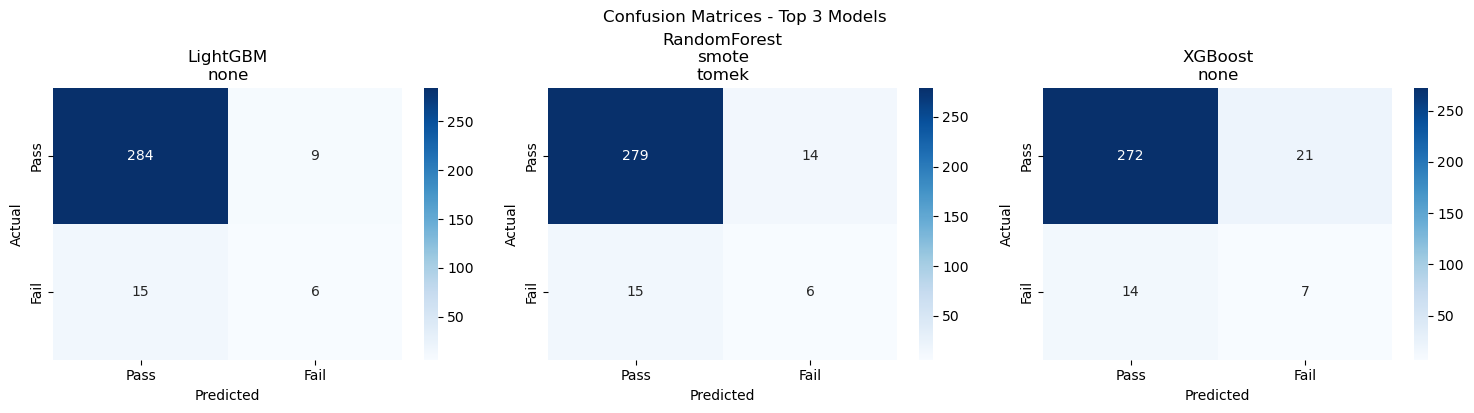

In [25]:
# Cell 21: Confusion matrices for top 3

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

top_3_keys = [f"{row['model']}_{row['resampling']}" for _, row in top_3.iterrows()]

for ax, key in zip(axes, top_3_keys):
    if key in final_models:
        test_pred = final_models[key]['test_pred']
        cm = confusion_matrix(y_test, test_pred)
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                    xticklabels=['Pass', 'Fail'], yticklabels=['Pass', 'Fail'])
        ax.set_title(key.replace('_', '\n'))
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')

plt.tight_layout()
plt.suptitle('Confusion Matrices - Top 3 Models', y=1.02)
plt.show()

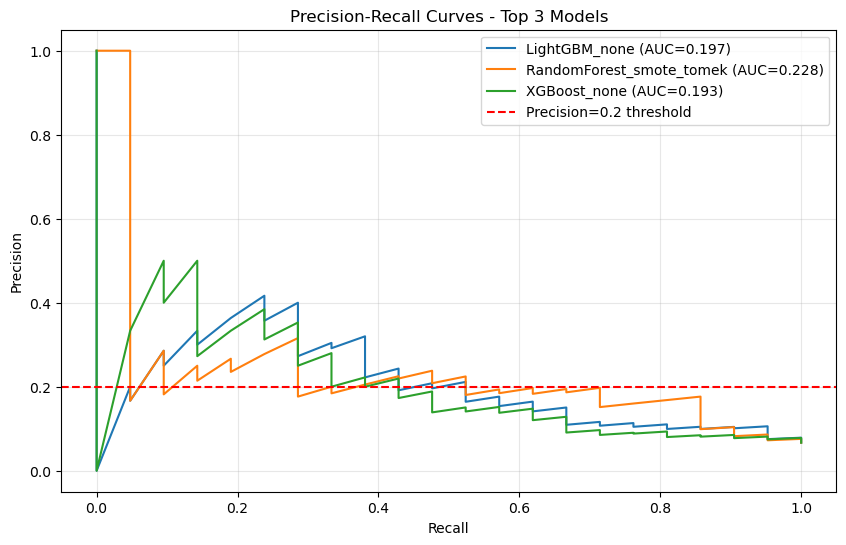

In [26]:
# Cell 22: PR curves for top 3

plt.figure(figsize=(10, 6))

for key in top_3_keys:
    if key in final_models:
        test_proba = final_models[key]['test_proba']
        precision, recall, _ = precision_recall_curve(y_test, test_proba)
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f"{key} (AUC={pr_auc:.3f})")

plt.axhline(y=0.2, color='r', linestyle='--', label='Precision=0.2 threshold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves - Top 3 Models')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()

## SHAP Interpretability

**Warning**: Do not change anything after viewing SHAP results. If changes are needed, rerun the entire pipeline.

In [27]:
# Cell 23: Select top 2-3 performers for SHAP analysis

# Select top 3 (accounting for potential winner's curse, we analyze multiple)
shap_models = []

for i, (_, row) in enumerate(top_3.iterrows()):
    key = f"{row['model']}_{row['resampling']}"
    if key in final_models:
        shap_models.append({
            'name': key,
            'model': final_models[key]['model'],
            'threshold': final_models[key]['threshold']
        })

print(f"Models selected for SHAP analysis: {[m['name'] for m in shap_models]}")

Models selected for SHAP analysis: ['LightGBM_none', 'RandomForest_smote_tomek', 'XGBoost_none']



SHAP Analysis: LightGBM_none


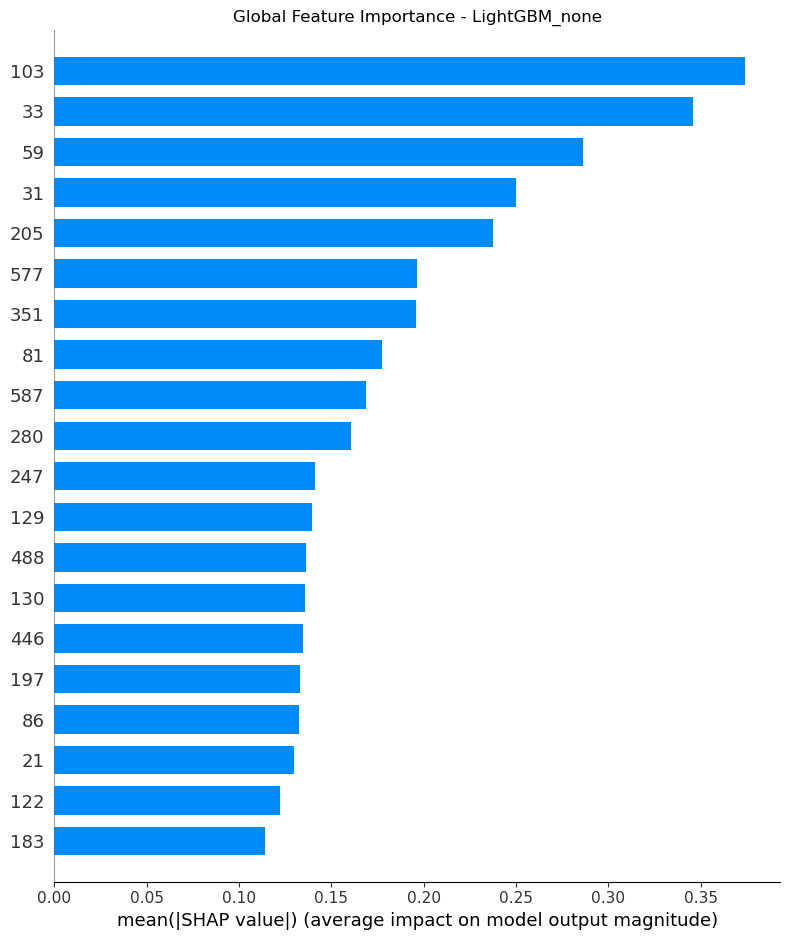

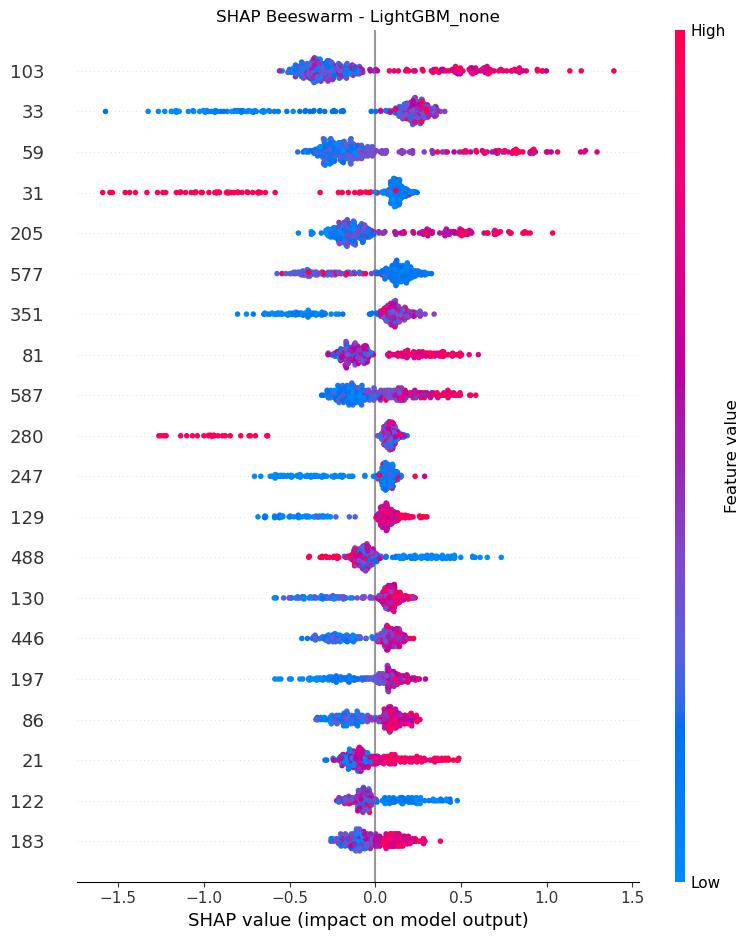


SHAP Analysis: RandomForest_smote_tomek


<Figure size 1000x800 with 0 Axes>

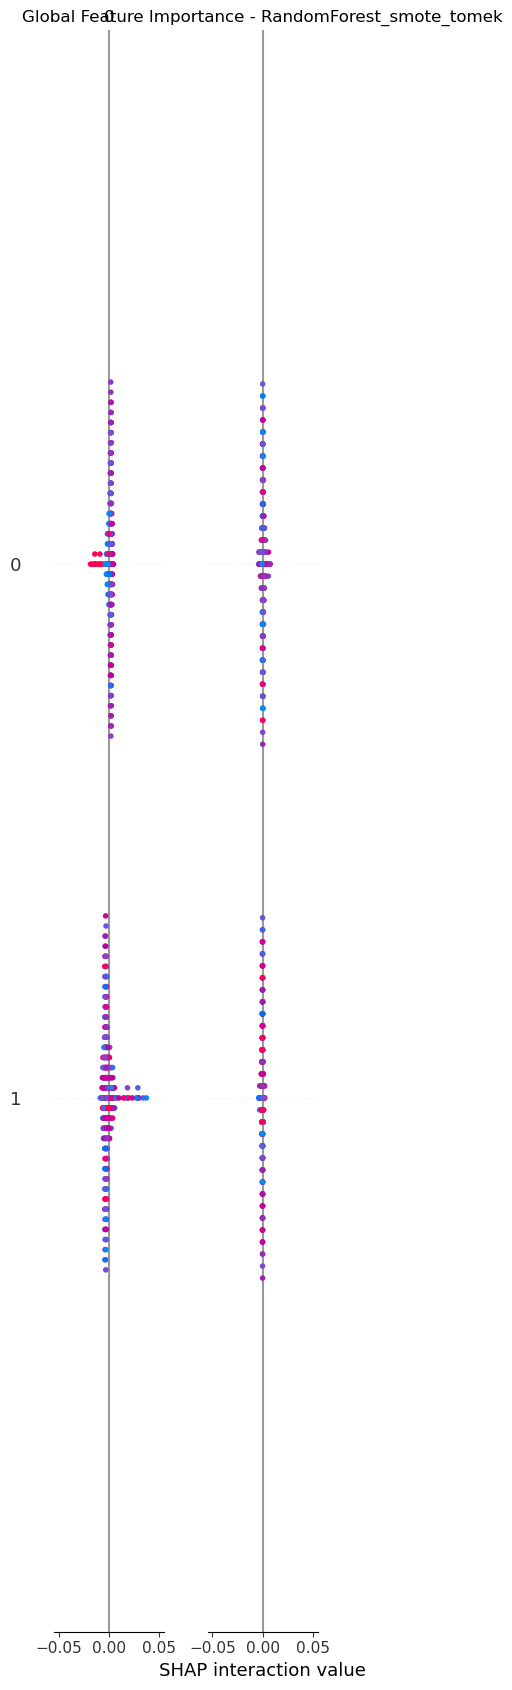

<Figure size 1000x800 with 0 Axes>

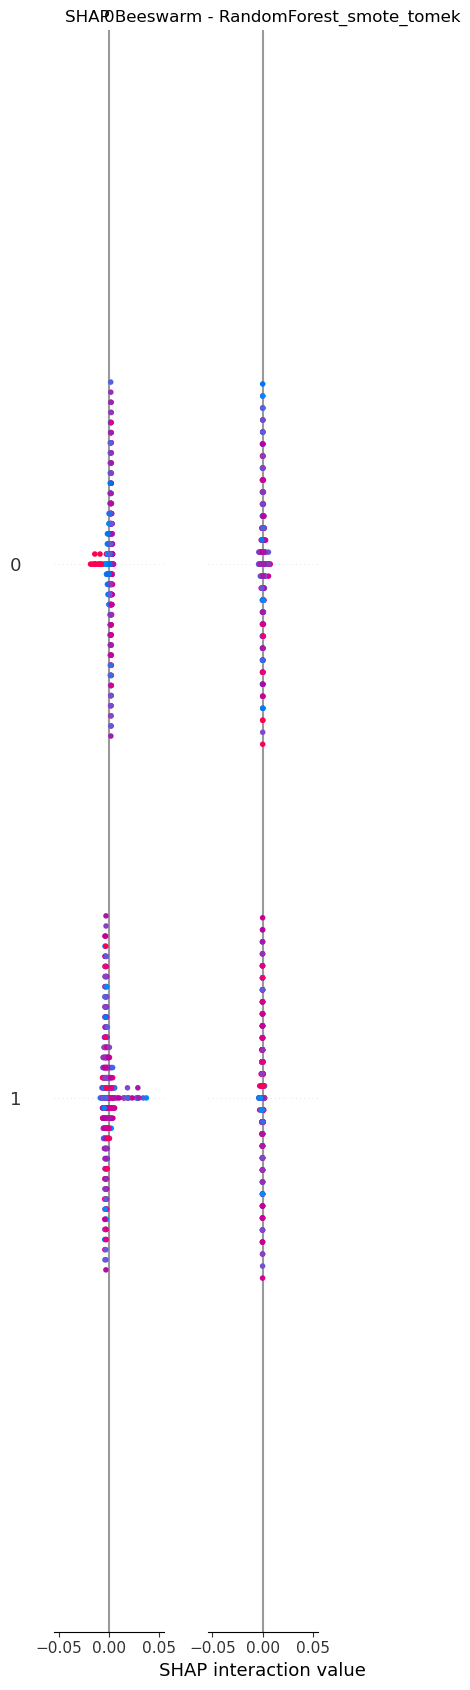


SHAP Analysis: XGBoost_none


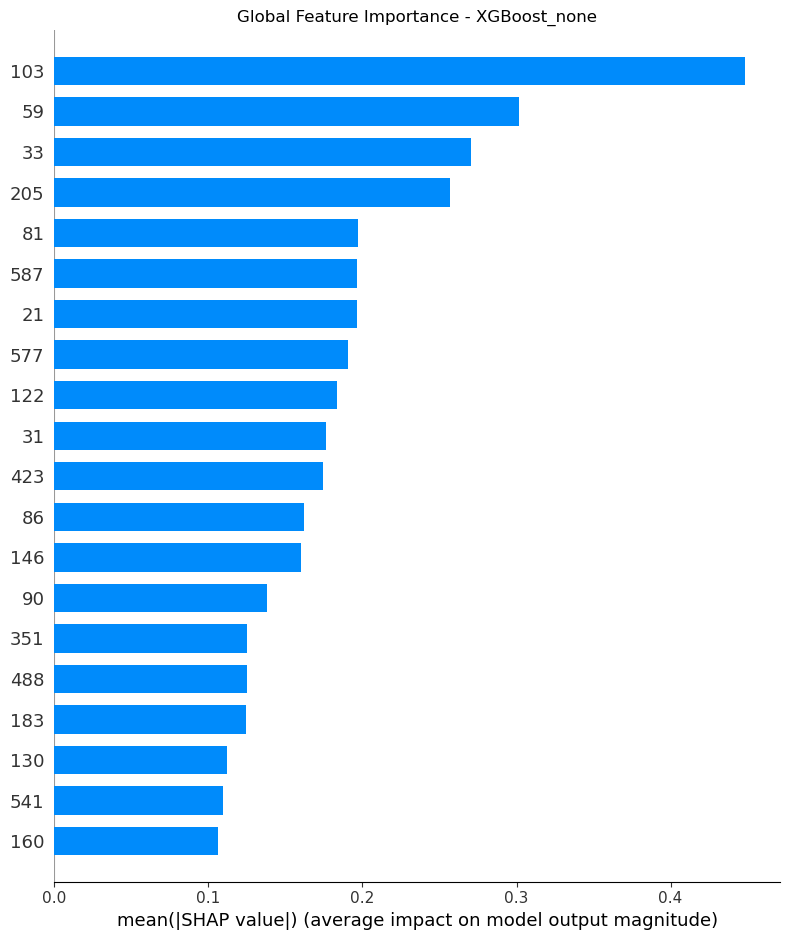

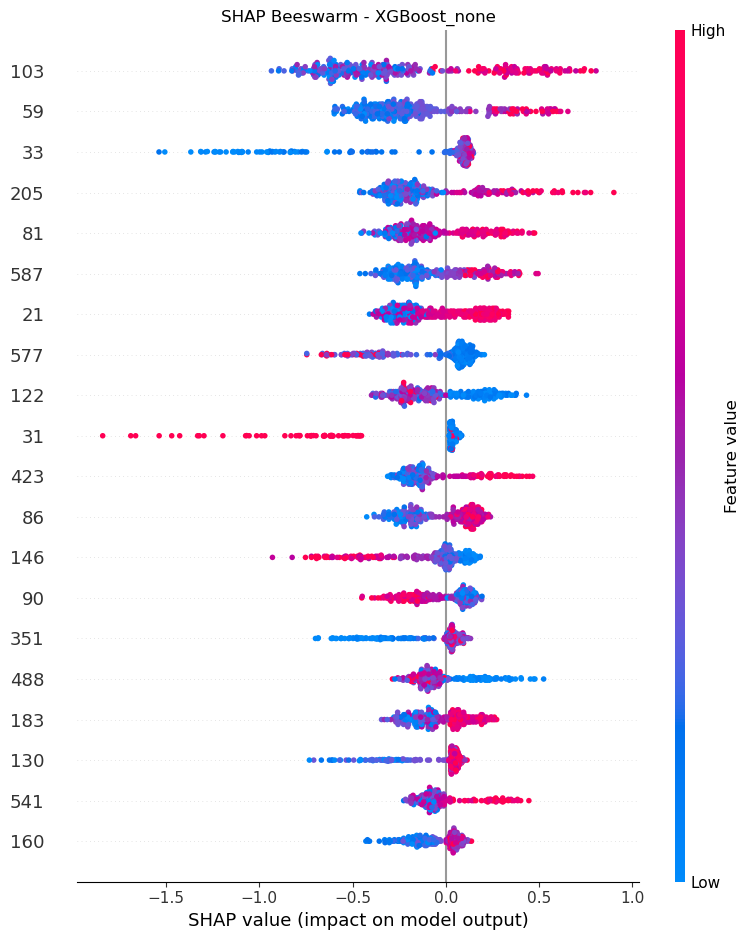

In [28]:
# Cell 24: Global SHAP - Bar and Beeswarm plots

for model_info in shap_models:
    model_name = model_info['name']
    model = model_info['model']
    
    print(f"\n{'='*60}")
    print(f"SHAP Analysis: {model_name}")
    print(f"{'='*60}")
    
    # Create SHAP explainer
    if 'LightGBM' in model_name or 'XGBoost' in model_name or 'RandomForest' in model_name:
        explainer = shap.TreeExplainer(model)
    else:
        # For Logistic Regression, use a sample for background
        background = shap.sample(X_train_final, 100, random_state=42)
        explainer = shap.LinearExplainer(model, background)
    
    # Calculate SHAP values on test set
    shap_values = explainer.shap_values(X_test_final)
    
    # Handle different SHAP output formats
    if isinstance(shap_values, list):
        # For classifiers that return [class_0, class_1]
        shap_values_display = shap_values[1]  # Use positive class
    else:
        shap_values_display = shap_values
    
    # Bar plot (global feature importance)
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values_display, X_test_final, plot_type='bar', 
                      max_display=20, show=False)
    plt.title(f'Global Feature Importance - {model_name}')
    plt.tight_layout()
    plt.show()
    
    # Beeswarm plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values_display, X_test_final, max_display=20, show=False)
    plt.title(f'SHAP Beeswarm - {model_name}')
    plt.tight_layout()
    plt.show()
    
    # Store for later use
    model_info['explainer'] = explainer
    model_info['shap_values'] = shap_values_display

In [29]:
# Cell 25: Local SHAP - Waterfall and Force plots for example cases

# Use first model for local explanations
model_info = shap_models[0]
model_name = model_info['name']
model = model_info['model']
threshold = model_info['threshold']
shap_values_display = model_info['shap_values']

print(f"\nLocal explanations for: {model_name}")
print("="*60)

# Get predictions
test_proba = model.predict_proba(X_test_final)[:, 1]
test_pred = (test_proba >= threshold).astype(int)

# Find example cases
tp_idx = np.where((test_pred == 1) & (y_test.values == 1))[0]
fn_idx = np.where((test_pred == 0) & (y_test.values == 1))[0]
fp_idx = np.where((test_pred == 1) & (y_test.values == 0))[0]

print(f"True Positives: {len(tp_idx)}")
print(f"False Negatives: {len(fn_idx)}")
print(f"False Positives: {len(fp_idx)}")

# Create SHAP Explanation object for waterfall plots
shap_exp = shap.Explanation(
    values=shap_values_display,
    base_values=model_info['explainer'].expected_value if not isinstance(model_info['explainer'].expected_value, list) 
                else model_info['explainer'].expected_value[1],
    data=X_test_final.values,
    feature_names=X_test_final.columns.tolist()
)


Local explanations for: LightGBM_none
True Positives: 6
False Negatives: 15
False Positives: 9



True Positive Example (index 60):
  Predicted probability: 0.314
  Actual: Fail


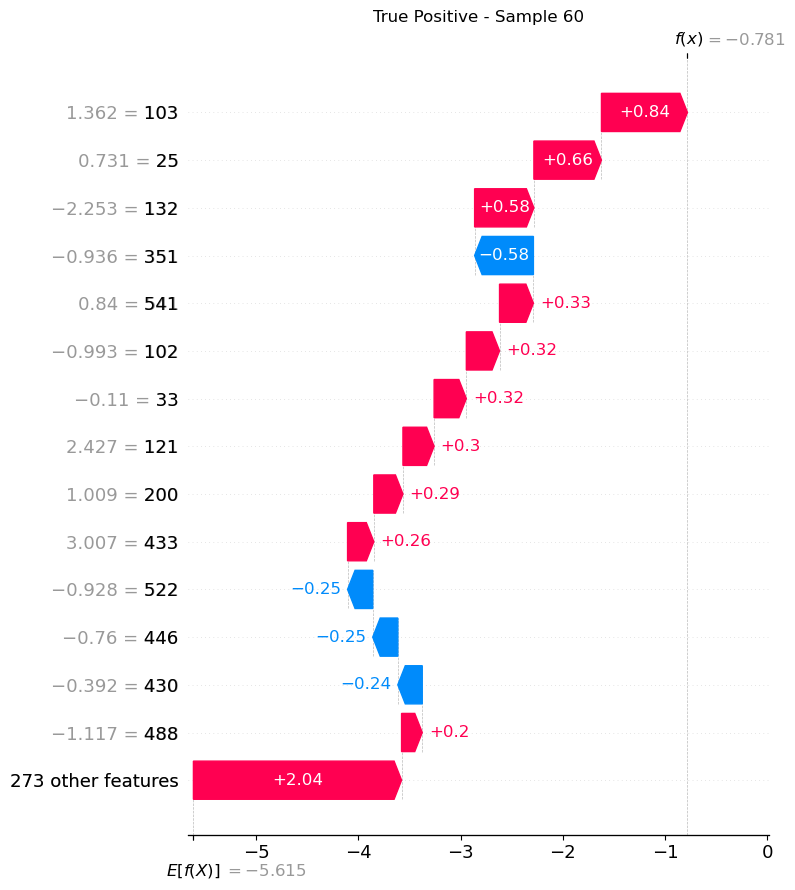


False Negative Example (index 37):
  Predicted probability: 0.002
  Actual: Fail (missed!)


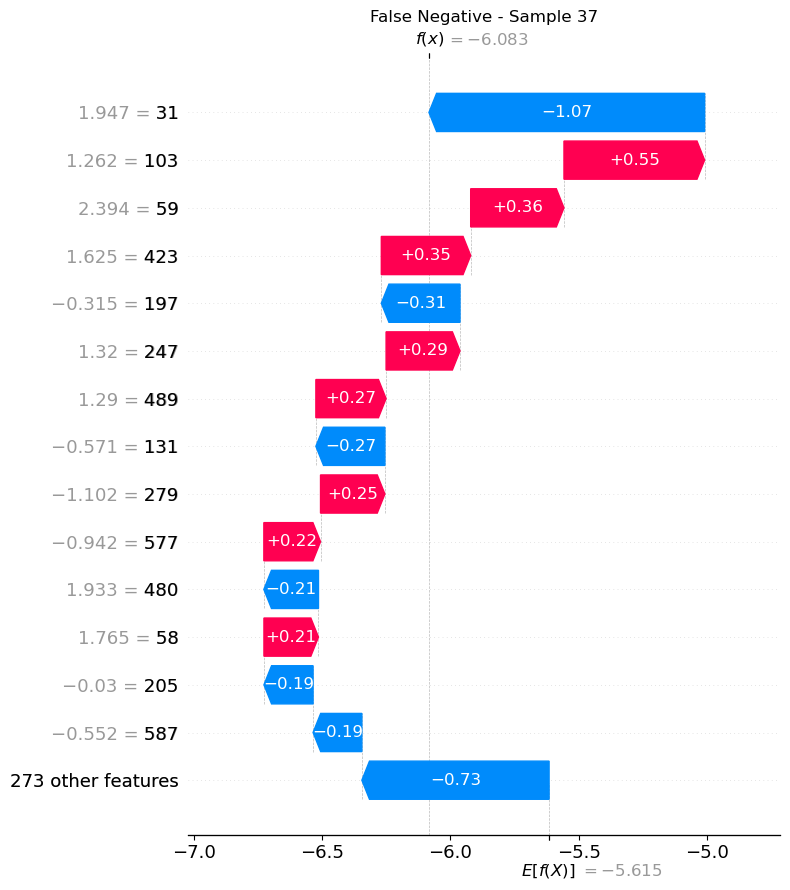


False Positive Example (index 58):
  Predicted probability: 0.154
  Actual: Pass (false alarm)


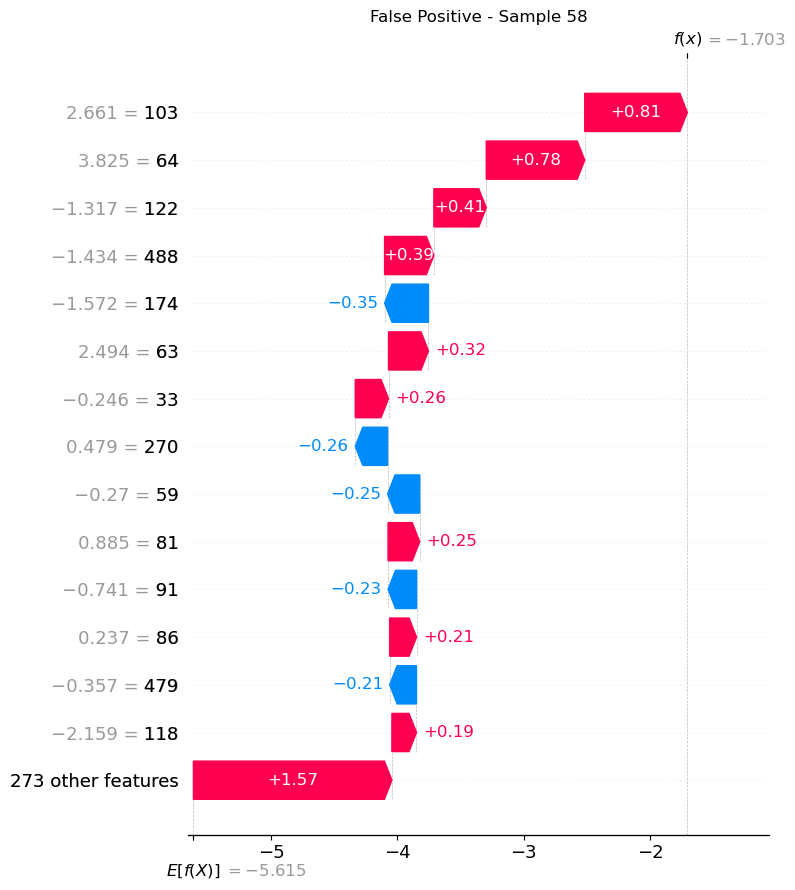

In [30]:
# Cell 25b: Waterfall plots for TP, FN, FP examples

# True Positive example
if len(tp_idx) > 0:
    idx = tp_idx[0]
    print(f"\nTrue Positive Example (index {idx}):")
    print(f"  Predicted probability: {test_proba[idx]:.3f}")
    print(f"  Actual: Fail")
    
    plt.figure(figsize=(10, 6))
    shap.plots.waterfall(shap_exp[idx], max_display=15, show=False)
    plt.title(f'True Positive - Sample {idx}')
    plt.tight_layout()
    plt.show()

# False Negative example
if len(fn_idx) > 0:
    idx = fn_idx[0]
    print(f"\nFalse Negative Example (index {idx}):")
    print(f"  Predicted probability: {test_proba[idx]:.3f}")
    print(f"  Actual: Fail (missed!)")
    
    plt.figure(figsize=(10, 6))
    shap.plots.waterfall(shap_exp[idx], max_display=15, show=False)
    plt.title(f'False Negative - Sample {idx}')
    plt.tight_layout()
    plt.show()

# False Positive example
if len(fp_idx) > 0:
    idx = fp_idx[0]
    print(f"\nFalse Positive Example (index {idx}):")
    print(f"  Predicted probability: {test_proba[idx]:.3f}")
    print(f"  Actual: Pass (false alarm)")
    
    plt.figure(figsize=(10, 6))
    shap.plots.waterfall(shap_exp[idx], max_display=15, show=False)
    plt.title(f'False Positive - Sample {idx}')
    plt.tight_layout()
    plt.show()

In [31]:
# Cell 26: Force plots for the same examples

# Initialize JS visualization
shap.initjs()

# Force plot for TP
if len(tp_idx) > 0:
    idx = tp_idx[0]
    print(f"\nForce Plot - True Positive (index {idx}):")
    display(shap.force_plot(
        shap_exp.base_values[idx] if hasattr(shap_exp.base_values, '__len__') and len(shap_exp.base_values) > 1 else shap_exp.base_values,
        shap_exp.values[idx],
        X_test_final.iloc[idx],
        feature_names=X_test_final.columns.tolist()
    ))

# Force plot for FN
if len(fn_idx) > 0:
    idx = fn_idx[0]
    print(f"\nForce Plot - False Negative (index {idx}):")
    display(shap.force_plot(
        shap_exp.base_values[idx] if hasattr(shap_exp.base_values, '__len__') and len(shap_exp.base_values) > 1 else shap_exp.base_values,
        shap_exp.values[idx],
        X_test_final.iloc[idx],
        feature_names=X_test_final.columns.tolist()
    ))


Force Plot - True Positive (index 60):



Force Plot - False Negative (index 37):



Feature Clustering Analysis for: LightGBM_none


82370it [07:15, 184.97it/s]                            


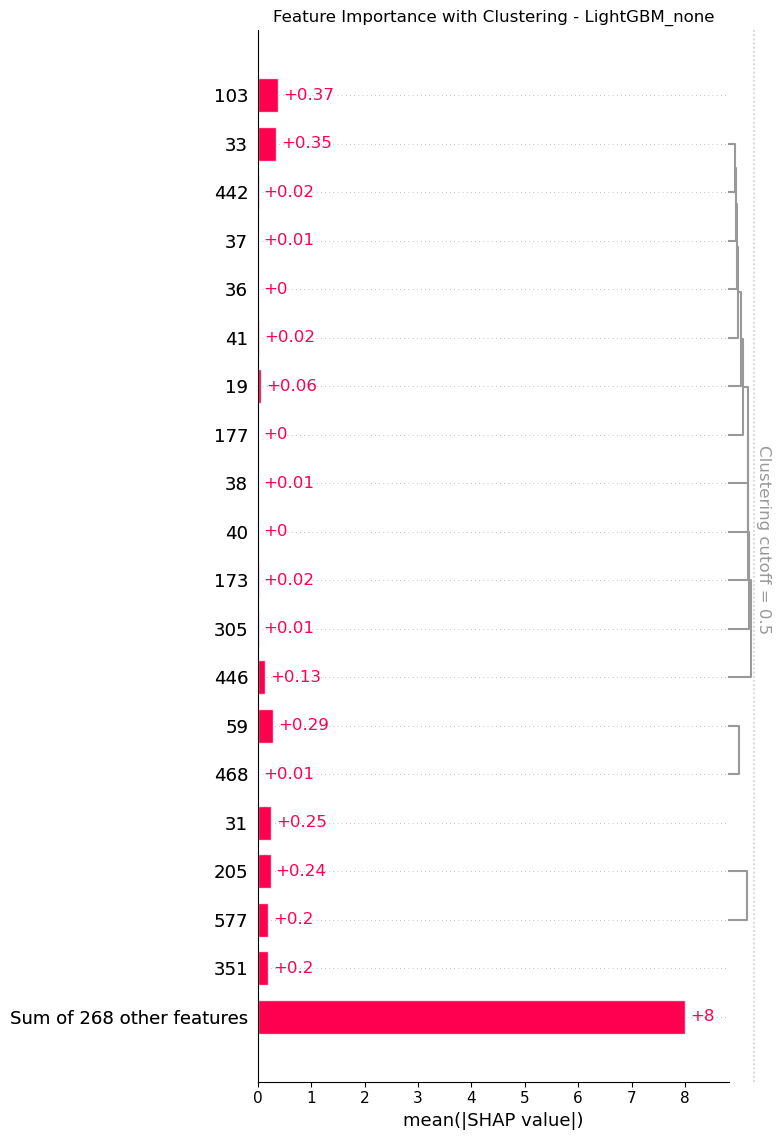

In [32]:
# Cell 27: Feature clustering (correlated features grouped)

model_info = shap_models[0]
shap_values_display = model_info['shap_values']

print(f"\nFeature Clustering Analysis for: {model_info['name']}")
print("="*60)

# Hierarchical clustering of features based on SHAP values
plt.figure(figsize=(12, 8))

# Create clustering plot
clustering = shap.utils.hclust(X_test_final, y_test)

shap.plots.bar(
    shap.Explanation(
        values=shap_values_display,
        base_values=model_info['explainer'].expected_value if not isinstance(model_info['explainer'].expected_value, list) 
                    else model_info['explainer'].expected_value[1],
        data=X_test_final.values,
        feature_names=X_test_final.columns.tolist()
    ),
    max_display=20,
    clustering=clustering,
    clustering_cutoff=0.5,
    show=False
)
plt.title(f'Feature Importance with Clustering - {model_info["name"]}')
plt.tight_layout()
plt.show()

## Summary and Conclusions

In [33]:
# Cell 28: Final summary

print("="*80)
print("FINAL ANALYSIS SUMMARY")
print("="*80)

print("\n1. DATA OVERVIEW:")
print(f"   - Original features: {feature_engineering_log['original_features']}")
print(f"   - Final features after engineering: {len(final_feature_cols_with_indicators)}")
print(f"   - Training samples: {len(y_train)}")
print(f"   - Test samples: {len(y_test)}")
print(f"   - Defect rate: {y_train.mean():.2%}")

print("\n2. BEST MODEL CONFIGURATION:")
best_result = test_results_df.iloc[0]
print(f"   - Model: {best_result['model']}")
print(f"   - Resampling: {best_result['resampling']}")
print(f"   - Threshold (from CV): {best_result['threshold']:.3f}")

print("\n3. TEST SET PERFORMANCE (using fixed threshold from CV):")
print(f"   - F1 Score: {best_result['f1']:.4f}")
print(f"   - PR-AUC: {best_result['pr_auc']:.4f}")
print(f"   - Recall: {best_result['recall']:.4f}")
print(f"   - Precision: {best_result['precision']:.4f}")

print("\n4. KEY INSIGHTS FROM SHAP:")
if shap_models:
    # Get top features
    mean_abs_shap = np.abs(shap_models[0]['shap_values']).mean(axis=0)
    top_features_idx = np.argsort(mean_abs_shap)[-5:][::-1]
    top_features = [X_test_final.columns[i] for i in top_features_idx]
    print(f"   Top 5 most important features:")
    for i, feat in enumerate(top_features, 1):
        print(f"   {i}. {feat}")

print("\n" + "="*80)
print("Analysis complete!")
print("="*80)

FINAL ANALYSIS SUMMARY

1. DATA OVERVIEW:
   - Original features: 590
   - Final features after engineering: 287
   - Training samples: 1253
   - Test samples: 314
   - Defect rate: 6.62%

2. BEST MODEL CONFIGURATION:
   - Model: LightGBM
   - Resampling: none
   - Threshold (from CV): 0.090

3. TEST SET PERFORMANCE (using fixed threshold from CV):
   - F1 Score: 0.3333
   - PR-AUC: 0.2149
   - Recall: 0.2857
   - Precision: 0.4000

4. KEY INSIGHTS FROM SHAP:
   Top 5 most important features:
   1. 103
   2. 33
   3. 59
   4. 31
   5. 205

Analysis complete!


## Defect Difficulty Analysis: Easy vs Hard Cases

Not all defects are equal. Some are consistently detected across multiple models while others evade even the best classifiers. Understanding this structure helps prioritize improvement efforts.

In [ ]:
# Cell 29: Analyze prediction overlap across all models for positive cases

print("="*80)
print("DEFECT DIFFICULTY ANALYSIS")
print("="*80)

# Get indices of actual positive cases in test set
positive_test_indices = np.where(y_test.values == 1)[0]
print(f"\nTotal defects in test set: {len(positive_test_indices)}")

# Collect predictions from all models for each positive case
defect_predictions = {}

for key, model_data in final_models.items():
    test_pred = model_data['test_pred']
    for idx in positive_test_indices:
        if idx not in defect_predictions:
            defect_predictions[idx] = {'models_detected': [], 'models_missed': []}
        
        if test_pred[idx] == 1:
            defect_predictions[idx]['models_detected'].append(key)
        else:
            defect_predictions[idx]['models_missed'].append(key)

# Calculate detection rate for each defect
defect_difficulty = []
for idx in positive_test_indices:
    n_detected = len(defect_predictions[idx]['models_detected'])
    n_total = len(final_models)
    detection_rate = n_detected / n_total
    
    defect_difficulty.append({
        'test_index': idx,
        'original_index': y_test.index[idx],
        'n_models_detected': n_detected,
        'n_models_total': n_total,
        'detection_rate': detection_rate,
        'models_detected': defect_predictions[idx]['models_detected'],
        'models_missed': defect_predictions[idx]['models_missed']
    })

defect_df = pd.DataFrame(defect_difficulty)
defect_df = defect_df.sort_values('detection_rate', ascending=False)

print("\nDefect Detection Summary by Case:")
print("-"*80)
for _, row in defect_df.iterrows():
    difficulty = "EASY" if row['detection_rate'] >= 0.5 else ("MEDIUM" if row['detection_rate'] >= 0.2 else "HARD")
    print(f"Defect at test idx {row['test_index']:3d}: {row['n_models_detected']:2d}/{row['n_models_total']} models detected ({row['detection_rate']:.1%}) - {difficulty}")


In [ ]:
# Cell 30: Categorize defects into Easy, Medium, Hard

# Define difficulty categories
easy_defects = defect_df[defect_df['detection_rate'] >= 0.5]
medium_defects = defect_df[(defect_df['detection_rate'] >= 0.2) & (defect_df['detection_rate'] < 0.5)]
hard_defects = defect_df[defect_df['detection_rate'] < 0.2]

print("="*80)
print("DEFECT DIFFICULTY CATEGORIES")
print("="*80)

print(f"\n📗 EASY DEFECTS (≥50% of models detect): {len(easy_defects)} cases")
print(f"   These defects have clear signatures that most models can identify.")
if len(easy_defects) > 0:
    print(f"   Test indices: {easy_defects['test_index'].tolist()}")
    for _, row in easy_defects.iterrows():
        print(f"   - Idx {row['test_index']}: Detected by {row['n_models_detected']} models including: {', '.join(row['models_detected'][:5])}")

print(f"\n📙 MEDIUM DEFECTS (20-50% of models detect): {len(medium_defects)} cases")
print(f"   These defects are detectable but require the right model configuration.")
if len(medium_defects) > 0:
    print(f"   Test indices: {medium_defects['test_index'].tolist()}")
    for _, row in medium_defects.iterrows():
        detected_models = row['models_detected'][:3] if len(row['models_detected']) > 0 else ['None']
        print(f"   - Idx {row['test_index']}: Detected by {row['n_models_detected']} models: {', '.join(detected_models)}")

print(f"\n📕 HARD DEFECTS (<20% of models detect): {len(hard_defects)} cases")
print(f"   These defects have unusual signatures that current features cannot capture.")
if len(hard_defects) > 0:
    print(f"   Test indices: {hard_defects['test_index'].tolist()}")
    for _, row in hard_defects.iterrows():
        if row['n_models_detected'] > 0:
            print(f"   - Idx {row['test_index']}: Only detected by: {', '.join(row['models_detected'])}")
        else:
            print(f"   - Idx {row['test_index']}: MISSED BY ALL MODELS")

# Summary statistics
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
print(f"Easy defects:   {len(easy_defects):2d} ({len(easy_defects)/len(defect_df)*100:.1f}%) - Reliably detectable")
print(f"Medium defects: {len(medium_defects):2d} ({len(medium_defects)/len(defect_df)*100:.1f}%) - Partially detectable")
print(f"Hard defects:   {len(hard_defects):2d} ({len(hard_defects)/len(defect_df)*100:.1f}%) - Need new approaches")

In [ ]:
# Cell 31: Visualize detection rate distribution

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of detection rates
ax1 = axes[0]
detection_rates = defect_df['detection_rate'].values
ax1.hist(detection_rates, bins=np.arange(0, 1.1, 0.1), edgecolor='black', alpha=0.7)
ax1.axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='Easy threshold (50%)')
ax1.axvline(x=0.2, color='orange', linestyle='--', linewidth=2, label='Medium threshold (20%)')
ax1.set_xlabel('Detection Rate (fraction of models)')
ax1.set_ylabel('Number of Defects')
ax1.set_title('Distribution of Defect Detection Difficulty')
ax1.legend()
ax1.set_xticks(np.arange(0, 1.1, 0.1))

# Stacked bar showing which models detect which defects
ax2 = axes[1]
model_names = list(final_models.keys())

# Create matrix: rows = defects (sorted by difficulty), cols = models
detection_matrix = np.zeros((len(defect_df), len(model_names)))
for i, (_, row) in enumerate(defect_df.iterrows()):
    for j, model in enumerate(model_names):
        if model in row['models_detected']:
            detection_matrix[i, j] = 1

# Plot heatmap
im = ax2.imshow(detection_matrix, aspect='auto', cmap='RdYlGn', vmin=0, vmax=1)
ax2.set_xlabel('Model Configuration')
ax2.set_ylabel('Defect Case (sorted by difficulty)')
ax2.set_title('Detection Matrix: Which Models Catch Which Defects')
ax2.set_xticks(range(len(model_names)))
ax2.set_xticklabels([m.replace('_', '\n') for m in model_names], rotation=45, ha='right', fontsize=7)
ax2.set_yticks(range(len(defect_df)))
ax2.set_yticklabels([f"Idx {row['test_index']}" for _, row in defect_df.iterrows()], fontsize=8)

# Add colorbar
cbar = plt.colorbar(im, ax=ax2, shrink=0.8)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Missed', 'Detected'])

plt.tight_layout()
plt.show()

# Print detection rate statistics
print("\nDetection Rate Statistics:")
print(f"  Mean: {detection_rates.mean():.1%}")
print(f"  Median: {np.median(detection_rates):.1%}")
print(f"  Min: {detection_rates.min():.1%}")
print(f"  Max: {detection_rates.max():.1%}")

In [ ]:
# Cell 32: SHAP Waterfall plots for Easy, Medium, Hard cases

# Use the best model's SHAP explainer
best_model_info = shap_models[0]  # LightGBM_none
shap_values_all = best_model_info['shap_values']
explainer = best_model_info['explainer']
base_value = explainer.expected_value if not isinstance(explainer.expected_value, list) else explainer.expected_value[1]

print("="*80)
print("SHAP ANALYSIS BY DEFECT DIFFICULTY")
print(f"Using model: {best_model_info['name']}")
print("="*80)

# Get test probabilities for context
test_proba = final_models[best_model_info['name']]['test_proba']
threshold = best_model_info['threshold']

# Select representative cases from each category
def get_representative_case(df, category_name):
    """Get the most representative case (middle of the category)"""
    if len(df) == 0:
        return None
    # Sort by detection rate and pick middle
    sorted_df = df.sort_values('detection_rate')
    mid_idx = len(sorted_df) // 2
    return sorted_df.iloc[mid_idx]

easy_case = get_representative_case(easy_defects, "Easy") if len(easy_defects) > 0 else None
medium_case = get_representative_case(medium_defects, "Medium") if len(medium_defects) > 0 else None
hard_case = get_representative_case(hard_defects, "Hard") if len(hard_defects) > 0 else None

# Create SHAP Explanation object
shap_exp = shap.Explanation(
    values=shap_values_all,
    base_values=base_value,
    data=X_test_final.values,
    feature_names=X_test_final.columns.tolist()
)

# Plot waterfall for each difficulty level
cases_to_plot = [
    ("EASY", easy_case, "green"),
    ("MEDIUM", medium_case, "orange"),
    ("HARD", hard_case, "red")
]

for difficulty, case, color in cases_to_plot:
    if case is not None:
        idx = case['test_index']
        prob = test_proba[idx]
        detected_by = case['n_models_detected']
        total_models = case['n_models_total']
        
        print(f"\n{'='*60}")
        print(f"📊 {difficulty} DEFECT - Test Index {idx}")
        print(f"{'='*60}")
        print(f"Detection rate: {case['detection_rate']:.1%} ({detected_by}/{total_models} models)")
        print(f"Predicted probability (by {best_model_info['name']}): {prob:.3f}")
        print(f"Threshold: {threshold:.3f}")
        print(f"This model's prediction: {'DETECTED' if prob >= threshold else 'MISSED'}")
        if detected_by > 0:
            print(f"Models that detected it: {', '.join(case['models_detected'][:5])}")
        
        plt.figure(figsize=(12, 6))
        shap.plots.waterfall(shap_exp[idx], max_display=15, show=False)
        plt.title(f'{difficulty} Defect (Test Idx {idx}) - Detection Rate: {case["detection_rate"]:.1%}', 
                  fontsize=12, fontweight='bold', color=color)
        plt.tight_layout()
        plt.show()
    else:
        print(f"\n⚠️ No {difficulty} defect cases found in this test set.")

In [ ]:
# Cell 33: Compare feature values between Easy and Hard defects

print("="*80)
print("FEATURE COMPARISON: EASY vs HARD DEFECTS")
print("="*80)

# Get indices for each category
easy_indices = easy_defects['test_index'].tolist() if len(easy_defects) > 0 else []
hard_indices = hard_defects['test_index'].tolist() if len(hard_defects) > 0 else []

# Get top features from SHAP
mean_abs_shap = np.abs(shap_values_all).mean(axis=0)
top_10_feature_idx = np.argsort(mean_abs_shap)[-10:][::-1]
top_10_features = [X_test_final.columns[i] for i in top_10_feature_idx]

print(f"\nAnalyzing top 10 SHAP features: {top_10_features}")

if len(easy_indices) > 0 and len(hard_indices) > 0:
    # Compare feature statistics
    comparison_data = []
    
    for feat in top_10_features:
        easy_values = X_test_final.iloc[easy_indices][feat].values
        hard_values = X_test_final.iloc[hard_indices][feat].values
        normal_values = X_test_final[y_test.values == 0][feat].values  # Non-defect cases
        
        comparison_data.append({
            'Feature': feat,
            'Easy Mean': np.mean(easy_values),
            'Easy Std': np.std(easy_values),
            'Hard Mean': np.mean(hard_values),
            'Hard Std': np.std(hard_values),
            'Normal Mean': np.mean(normal_values),
            'Normal Std': np.std(normal_values),
            'Easy vs Normal': (np.mean(easy_values) - np.mean(normal_values)) / (np.std(normal_values) + 1e-10),
            'Hard vs Normal': (np.mean(hard_values) - np.mean(normal_values)) / (np.std(normal_values) + 1e-10)
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print("\nFeature Statistics (standardized values):")
    print("-"*80)
    print(comparison_df[['Feature', 'Easy Mean', 'Hard Mean', 'Normal Mean', 'Easy vs Normal', 'Hard vs Normal']].to_string(index=False))
    
    print("\n" + "="*80)
    print("KEY INSIGHT:")
    print("="*80)
    print("'Easy vs Normal' shows how many std deviations easy defects differ from normal.")
    print("'Hard vs Normal' shows how many std deviations hard defects differ from normal.")
    print("\nIf Easy defects show large deviations but Hard defects don't, the hard defects")
    print("have 'normal-looking' sensor readings - they may require different features to detect.")
    
else:
    print("\n⚠️ Need both Easy and Hard defect cases for comparison.")

In [ ]:
# Cell 34: Visualize feature distributions for Easy vs Hard defects

if len(easy_indices) > 0 and len(hard_indices) > 0:
    # Select top 6 features for visualization
    top_6_features = top_10_features[:6]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for ax, feat in zip(axes, top_6_features):
        # Get values for each group
        normal_vals = X_test_final[y_test.values == 0][feat].values
        easy_vals = X_test_final.iloc[easy_indices][feat].values
        hard_vals = X_test_final.iloc[hard_indices][feat].values
        
        # Create violin plots or box plots
        data = [normal_vals, easy_vals, hard_vals]
        positions = [1, 2, 3]
        
        parts = ax.violinplot(data, positions=positions, showmeans=True, showmedians=True)
        
        # Color the violins
        colors = ['lightblue', 'lightgreen', 'lightcoral']
        for pc, color in zip(parts['bodies'], colors):
            pc.set_facecolor(color)
            pc.set_alpha(0.7)
        
        # Add scatter points for Easy and Hard
        ax.scatter([2]*len(easy_vals), easy_vals, c='green', s=50, alpha=0.7, label='Easy defects', zorder=5)
        ax.scatter([3]*len(hard_vals), hard_vals, c='red', s=50, alpha=0.7, label='Hard defects', zorder=5)
        
        ax.set_xticks(positions)
        ax.set_xticklabels(['Normal\n(n={})'.format(len(normal_vals)), 
                            'Easy\n(n={})'.format(len(easy_vals)), 
                            'Hard\n(n={})'.format(len(hard_vals))])
        ax.set_title(f'Feature: {feat}')
        ax.set_ylabel('Standardized Value')
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Feature Distributions: Normal vs Easy Defects vs Hard Defects', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\n💡 INTERPRETATION:")
    print("- Green points (Easy defects): Clearly separated from Normal distribution")
    print("- Red points (Hard defects): May overlap with Normal distribution")
    print("- If Hard defects overlap with Normal, current features cannot distinguish them")
else:
    print("⚠️ Need both Easy and Hard defect cases for visualization.")

In [ ]:
# Cell 35: Recommendations for Stakeholders and Engineers

print("="*80)
print("RECOMMENDATIONS FOR STAKEHOLDERS AND ENGINEERS")
print("="*80)

print("""
┌─────────────────────────────────────────────────────────────────────────────┐
│                        DEFECT DIFFICULTY SUMMARY                            │
└─────────────────────────────────────────────────────────────────────────────┘
""")

n_easy = len(easy_defects)
n_medium = len(medium_defects)
n_hard = len(hard_defects)
n_total = len(defect_df)

print(f"Of the {n_total} defects in the test set:")
print(f"  ✅ {n_easy} ({n_easy/n_total*100:.0f}%) are EASY to detect - reliably caught by most models")
print(f"  ⚠️  {n_medium} ({n_medium/n_total*100:.0f}%) are MEDIUM difficulty - caught by some models")
print(f"  ❌ {n_hard} ({n_hard/n_total*100:.0f}%) are HARD to detect - missed by most/all models")

print("""
┌─────────────────────────────────────────────────────────────────────────────┐
│                     WHAT THIS MEANS FOR YOUR PROCESS                        │
└─────────────────────────────────────────────────────────────────────────────┘

1. EASY DEFECTS - Low-Hanging Fruit 🍎
   - These defects show CLEAR anomalies in key sensors
   - Current monitoring with sensor thresholds would catch most of these
   - Recommendation: Implement automated alerts when sensors 103, 33, 59 
     exceed their normal operating ranges

2. MEDIUM DEFECTS - Model-Dependent Detection 🔍
   - These defects have subtle signatures that require ML to detect
   - Different model configurations catch different subsets
   - Recommendation: Consider an ensemble approach or human review
     for cases near the decision boundary

3. HARD DEFECTS - The Blind Spots 🔮
   - These defects have NORMAL-LOOKING sensor readings
   - Current sensors may not capture the root cause
   
   POSSIBLE REASONS:
   a) Different failure mode: These defects may arise from a different 
      physical process not captured by current sensors
   b) Delayed effect: The anomaly may occur earlier/later than when 
      measurements are taken
   c) Missing sensors: Key process parameters may not be monitored
   d) Interaction effects: The defect may require specific combinations
      of sensor values not easily detected by current features

┌─────────────────────────────────────────────────────────────────────────────┐
│                     RECOMMENDED ACTIONS FOR ENGINEERS                       │
└─────────────────────────────────────────────────────────────────────────────┘

1. INVESTIGATE HARD CASES:
   - Pull the actual wafers/units corresponding to hard defect cases
   - Conduct root cause analysis: What caused these specific failures?
   - Compare with easy defect cases: How are the failure modes different?

2. SENSOR REVIEW:
   - Are there process steps without sensor coverage?
   - Could we add sensors for temperature/pressure/flow at critical points?
   - Consider time-series features: rate of change, variance, patterns

3. FEATURE ENGINEERING COLLABORATION:
   - What domain knowledge could help create new features?
   - Are there known "recipes" or process windows that correlate with quality?
   - Could we incorporate upstream/downstream process data?

4. DATA COLLECTION:
   - For the hard defect cases, what additional data could we collect?
   - Would higher-frequency sampling help?
   - Are there visual inspection features we could quantify?
""")

# Print specific indices for investigation
print("┌─────────────────────────────────────────────────────────────────────────────┐")
print("│                     SPECIFIC CASES TO INVESTIGATE                           │")
print("└─────────────────────────────────────────────────────────────────────────────┘")
print()
print("HARD DEFECTS (require investigation):")
if len(hard_defects) > 0:
    for _, row in hard_defects.iterrows():
        original_idx = row['original_index']
        print(f"  - Original dataset row {original_idx}: Missed by {16-row['n_models_detected']}/16 models")
else:
    print("  (None in this test set)")

print()
print("EASY DEFECTS (for comparison - what makes them detectable?):")
if len(easy_defects) > 0:
    for _, row in easy_defects.iterrows():
        original_idx = row['original_index']
        print(f"  - Original dataset row {original_idx}: Detected by {row['n_models_detected']}/16 models")
else:
    print("  (None in this test set)")